#**CELL 1 - Setup & Caricamento Dataset Fixed**

In [ ]:
# ============================================================================
# CELL 1: Setup & Caricamento Dataset Fixed
# ============================================================================
"""
IMPETUS_EDA.ipynb - Exploratory Data Analysis
Autore: Alessandro Ambrosio

OBIETTIVO:
Analisi esplorativa dataset Banister fixed per validare qualità dati e
identificare pattern per le due pipeline di regressione:
- Pipeline A: performance_score_0_10 (0-10)
- Pipeline B: injury_risk_score (0-10)

NOTE POST "TARGET FIX":
- ACWR e injury_risk_score contengono NaN nei giorni warm-up (acwr_valid=False).
- Tutte le analisi/plot su ACWR e injury_risk_score vanno fatte su df_valid = df[acwr_valid].
- Soglie interpretative: sweet spot 0.8–1.3, danger zone ACWR >= 1.5 (Gabbett 2016).

RIFERIMENTI:
- Gabbett 2016: sweet spot ~0.8–1.3 e danger zone >= 1.5
- Banister/Calvert: Fitness-Fatigue model (contesto dataset)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
np.random.seed(42)

print("=" * 80)
print("IMPETUS EDA - Exploratory Data Analysis")
print("=" * 80)
print()

DATA_DIR = Path('data/synth_set_level_v2')
df = pd.read_csv(DATA_DIR / 'banister_daily_sampled_fixed.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset caricato: {df.shape[0]:,} righe x {df.shape[1]} colonne\n")

# Costanti globali EDA (coerenti con target fix)
ACWR_SWEET_LOW = 0.8
ACWR_SWEET_HIGH = 1.3
ACWR_DANGER_THRESHOLD = 1.5

# Dataset helper
df_valid = df[df['acwr_valid'] & df['acwr'].notna()].copy()

print("Info dataset:")
print(f"   Periodo: {df['date'].min().date()} -> {df['date'].max().date()}")
print(f"   Users: {df['user_id'].nunique()}")
print(f"   Giorni per user (media): {len(df) / df['user_id'].nunique():.1f}")
print(f"   Giorni validi (ACWR): {len(df_valid):,} ({len(df_valid)/len(df)*100:.1f}%)")
print()

print("Distribuzione Experience (RIGHE-GIORNO, attesa sbilanciata):")
exp_dist = df['experience_label'].value_counts(normalize=True).sort_index() * 100
for level, pct in exp_dist.items():
    print(f"   {level}: {pct:.1f}%")

print("\nDistribuzione Experience (UTENTI):")
print(df[['user_id','experience_label']].drop_duplicates()['experience_label'].value_counts())


IMPETUS EDA - Exploratory Data Analysis

Dataset caricato: 106,571 righe x 16 colonne

Info dataset:
   Periodo: 2023-02-26 -> 2026-02-08
   Users: 510
   Giorni per user (media): 209.0
   Giorni validi (ACWR): 92,834 (87.1%)

Distribuzione Experience (RIGHE-GIORNO, attesa sbilanciata):
   Advanced: 57.2%
   Beginner: 12.9%
   Intermediate: 29.9%

Distribuzione Experience (UTENTI):
experience_label
Beginner        170
Intermediate    170
Advanced        170
Name: count, dtype: int64


#**CELL 2 - ACWR Distribution & Spike Detection**


SEZIONE 1: ACWR DISTRIBUTION & SPIKE DETECTION (solo validi)

STATISTICHE ACWR (solo validi):
count    92834.000000
mean         1.029947
std          0.165656
min          0.300000
25%          0.925439
50%          1.030979
75%          1.133235
max          1.974102
Name: acwr, dtype: float64

SPIKE DETECTION (Threshold 1.5):
   Spike days: 476 (0.51%)
   Non-spike days: 92,358 (99.49%)

DISTRIBUZIONE PER ZONE (solo validi):
   Under/Deload zone        :  7,250 giorni (  7.8%) | ACWR medio: 0.713
   Sweet spot               : 80,968 giorni ( 87.2%) | ACWR medio: 1.038
   Caution zone             :  4,140 giorni (  4.5%) | ACWR medio: 1.366
   Danger zone (spike)      :    476 giorni (  0.5%) | ACWR medio: 1.586

ACWR PER EXPERIENCE LEVEL (solo validi):
   Advanced       : mean=1.036, std=0.145, spike_rate=0.19%
   Beginner       : mean=1.005, std=0.235, spike_rate=2.40%
   Intermediate   : mean=1.026, std=0.176, spike_rate=0.55%

[DATI GRAFICO - ACWR Distribution] (solo validi)
---

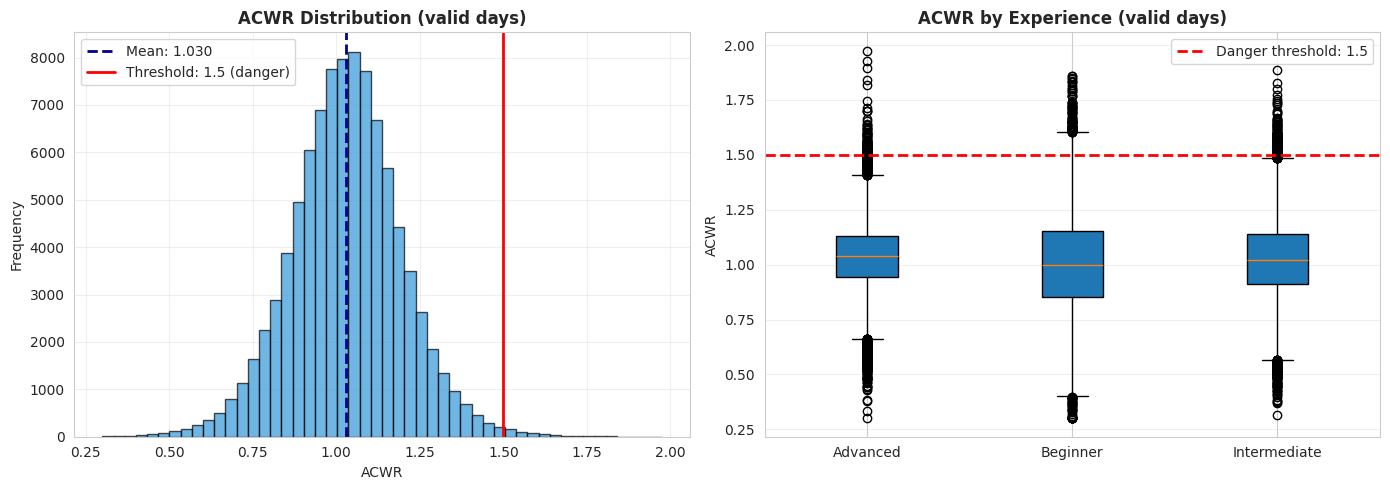

[OK] Visualizzazione salvata: visualizations/IMPETUS_EDA_1_ACWR.png


In [ ]:
# ============================================================================
# CELL 2: ACWR Distribution & Spike Detection (POST-FIX)
# ============================================================================
"""
Analisi ACWR su soli giorni validi (acwr_valid=True) per evitare NaN warm-up.
Spike threshold (danger zone): ACWR >= 1.5
"""

print("\n" + "=" * 80)
print("SEZIONE 1: ACWR DISTRIBUTION & SPIKE DETECTION (solo validi)")
print("=" * 80)

s_acwr = df_valid['acwr']

print("\nSTATISTICHE ACWR (solo validi):")
print(s_acwr.describe())
print()

spike_count = (s_acwr >= ACWR_DANGER_THRESHOLD).sum()
spike_pct = (s_acwr >= ACWR_DANGER_THRESHOLD).mean() * 100

print(f"SPIKE DETECTION (Threshold {ACWR_DANGER_THRESHOLD}):")
print(f"   Spike days: {spike_count:,} ({spike_pct:.2f}%)")
print(f"   Non-spike days: {len(s_acwr) - spike_count:,} ({100 - spike_pct:.2f}%)")
print()

zones = [
    (0, ACWR_SWEET_LOW, "Under/Deload zone"),
    (ACWR_SWEET_LOW, ACWR_SWEET_HIGH, "Sweet spot"),
    (ACWR_SWEET_HIGH, ACWR_DANGER_THRESHOLD, "Caution zone"),
    (ACWR_DANGER_THRESHOLD, 10, "Danger zone (spike)")
]

print("DISTRIBUZIONE PER ZONE (solo validi):")
for low, high, label in zones:
    mask_zone = (s_acwr >= low) & (s_acwr < high)
    count = mask_zone.sum()
    pct = count / len(s_acwr) * 100
    mean_acwr = s_acwr[mask_zone].mean()
    print(f"   {label:25s}: {count:6,} giorni ({pct:5.1f}%) | ACWR medio: {mean_acwr:.3f}")
print()

print("ACWR PER EXPERIENCE LEVEL (solo validi):")
for exp in sorted(df_valid['experience_label'].unique()):
    exp_data = df_valid[df_valid['experience_label'] == exp]['acwr']
    spike_exp = (exp_data >= ACWR_DANGER_THRESHOLD).mean() * 100
    print(f"   {exp:15s}: mean={exp_data.mean():.3f}, std={exp_data.std():.3f}, spike_rate={spike_exp:.2f}%")
print()

print("[DATI GRAFICO - ACWR Distribution] (solo validi)")
print("-" * 80)
hist_counts, hist_bins = np.histogram(s_acwr.values, bins=50)  # ok: niente NaN
print(f"   Bin edges (sample): {hist_bins[:10].round(3).tolist()}")
print(f"   Counts (primi 10): {hist_counts[:10].tolist()}")
print(f"   Max count: {hist_counts.max()} (bin {np.argmax(hist_counts)}, ACWR~{hist_bins[np.argmax(hist_counts)]:.3f})")
print("-" * 80)
print()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(s_acwr.values, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].axvline(s_acwr.mean(), color='darkblue', linestyle='--', linewidth=2, label=f'Mean: {s_acwr.mean():.3f}')
axes[0].axvline(ACWR_DANGER_THRESHOLD, color='red', linestyle='-', linewidth=2,
                label=f'Threshold: {ACWR_DANGER_THRESHOLD} (danger)')
axes[0].set_xlabel('ACWR')
axes[0].set_ylabel('Frequency')
axes[0].set_title('ACWR Distribution (valid days)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

exp_order = sorted(df_valid['experience_label'].unique())
axes[1].boxplot([df_valid[df_valid['experience_label'] == exp]['acwr'] for exp in exp_order],
                labels=exp_order, patch_artist=True)
axes[1].axhline(ACWR_DANGER_THRESHOLD, color='red', linestyle='--', linewidth=2,
                label=f'Danger threshold: {ACWR_DANGER_THRESHOLD}')
axes[1].set_ylabel('ACWR')
axes[1].set_title('ACWR by Experience (valid days)', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
viz_dir = Path('visualizations')
viz_dir.mkdir(exist_ok=True)
plt.savefig(viz_dir / 'IMPETUS_EDA_1_ACWR.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Visualizzazione salvata: visualizations/IMPETUS_EDA_1_ACWR.png")


#**CELL 3 - TSB (Training Stress Balance) Analysis**


SEZIONE 2: TSB (TRAINING STRESS BALANCE) ANALYSIS

STATISTICHE TSB:
count    106571.000000
mean        839.267499
std        1013.339851
min         -67.984449
25%         217.520101
50%         562.295524
75%        1137.057315
max       20011.652643
Name: TSB, dtype: float64

TSB SIGN DISTRIBUTION:
   TSB > 0 (forma buona): 102,156 giorni (95.9%)
   TSB <= 0 (affaticamento): 4,415 giorni (4.1%)

TSB PER EXPERIENCE LEVEL:
   Advanced       : mean=1231.7, std=1173.0, median=987.7
   Beginner       : mean=113.0, std=91.9, median=100.5
   Intermediate   : mean=401.3, std=290.6, median=363.5

CORRELATION TSB vs performance_score_0_10: 0.850



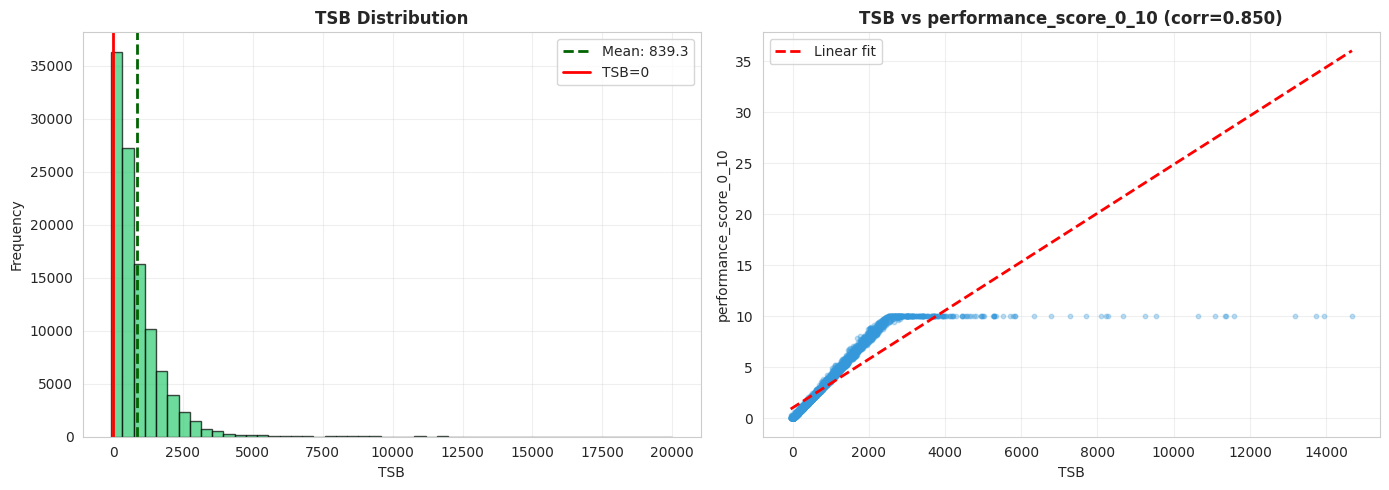

[OK] Visualizzazione salvata: visualizations/IMPETUS_EDA_2_TSB.png


In [ ]:
# ============================================================================
# CELL 3: TSB (Training Stress Balance) Analysis
# ============================================================================
print("\n" + "=" * 80)
print("SEZIONE 2: TSB (TRAINING STRESS BALANCE) ANALYSIS")
print("=" * 80)

print("\nSTATISTICHE TSB:")
print(df['TSB'].describe())
print()

tsb_positive = (df['TSB'] > 0).sum()
tsb_negative = (df['TSB'] <= 0).sum()
pct_pos = tsb_positive / len(df) * 100
pct_neg = tsb_negative / len(df) * 100

print("TSB SIGN DISTRIBUTION:")
print(f"   TSB > 0 (forma buona): {tsb_positive:,} giorni ({pct_pos:.1f}%)")
print(f"   TSB <= 0 (affaticamento): {tsb_negative:,} giorni ({pct_neg:.1f}%)")
print()

print("TSB PER EXPERIENCE LEVEL:")
for exp in sorted(df['experience_label'].unique()):
    exp_data = df[df['experience_label'] == exp]['TSB']
    print(f"   {exp:15s}: mean={exp_data.mean():.1f}, std={exp_data.std():.1f}, median={exp_data.median():.1f}")
print()

# Correlation TSB vs performance_score_0_10 (nota: è attesa alta perché lo score lo usa)
corr_tsb_perf = df[['TSB', 'performance_score_0_10']].corr().iloc[0, 1]
print(f"CORRELATION TSB vs performance_score_0_10: {corr_tsb_perf:.3f}")
print()

# Scatter
sample_size = min(5000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['TSB'], bins=50, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[0].axvline(df['TSB'].mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {df["TSB"].mean():.1f}')
axes[0].axvline(0, color='red', linestyle='-', linewidth=2, label='TSB=0')
axes[0].set_xlabel('TSB')
axes[0].set_ylabel('Frequency')
axes[0].set_title('TSB Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].scatter(df_sample['TSB'], df_sample['performance_score_0_10'], alpha=0.3, s=10, color='#3498db')
axes[1].set_xlabel('TSB')
axes[1].set_ylabel('performance_score_0_10')
axes[1].set_title(f'TSB vs performance_score_0_10 (corr={corr_tsb_perf:.3f})', fontweight='bold')
axes[1].grid(alpha=0.3)

z = np.polyfit(df_sample['TSB'], df_sample['performance_score_0_10'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_sample['TSB'].min(), df_sample['TSB'].max(), 100)
axes[1].plot(x_line, p(x_line), "r--", linewidth=2, label='Linear fit')
axes[1].legend()

plt.tight_layout()
plt.savefig(viz_dir / 'IMPETUS_EDA_2_TSB.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Visualizzazione salvata: visualizations/IMPETUS_EDA_2_TSB.png")


#**CELL 4 - Performance Score Distribution & Correlations**


SEZIONE 3: PERFORMANCE SCORE ANALYSIS (Pipeline A Target)

STATISTICHE PERFORMANCE SCORE (0-10):
count    106571.000000
mean          3.062173
std           2.796605
min           0.000000
25%           0.822231
50%           2.208326
75%           4.533501
max          10.000000
Name: performance_score_0_10, dtype: float64

DISTRIBUZIONE PER RANGE:
   0-2: 49,722 giorni ( 46.7%)
   2-4: 25,693 giorni ( 24.1%)
   4-6: 14,184 giorni ( 13.3%)
   6-8:  7,490 giorni (  7.0%)
   8-10:  9,482 giorni (  8.9%)

PERFORMANCE SCORE PER EXPERIENCE:
   Advanced       : mean=4.46, std=2.86, median=3.94
   Beginner       : mean=0.38, std=0.34, median=0.32
   Intermediate   : mean=1.53, std=1.12, median=1.37

CORRELATIONS performance_score_0_10 vs Features:
   fitness        :   0.848
   fatigue        :   0.758
   TSB            :   0.850

[DATI GRAFICO - Performance Score]
--------------------------------------------------------------------------------
   Range: [0, 10]
   Bin width: ~0.25
   Max c

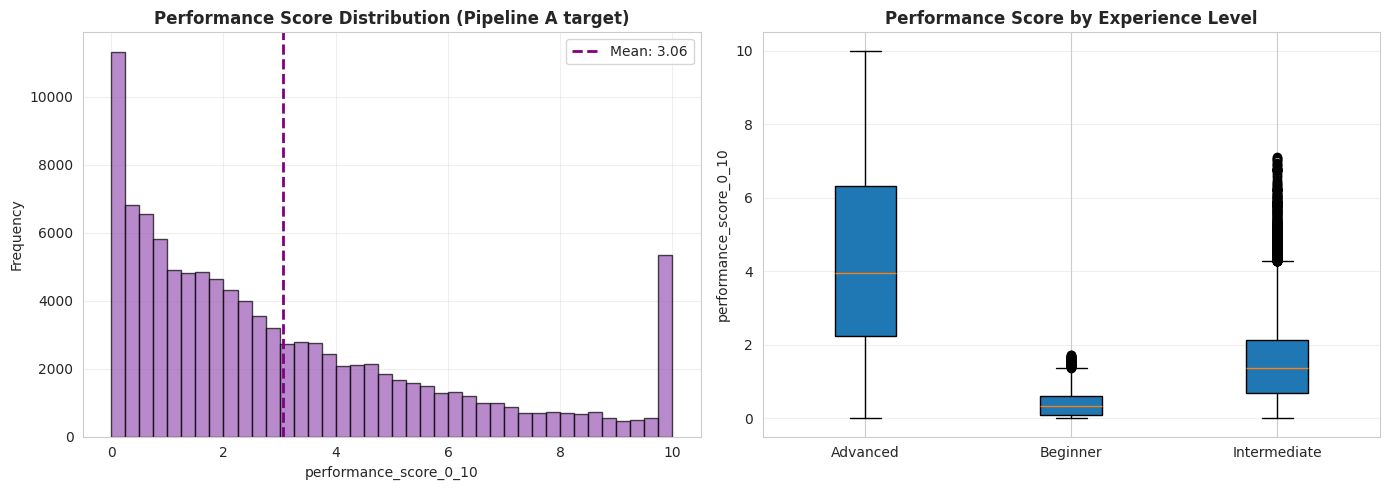

[OK] Visualizzazione salvata: visualizations/IMPETUS_EDA_3_Performance.png


In [ ]:
# ============================================================================
# CELL 4: Performance Score Distribution & Correlations
# ============================================================================
print("\n" + "=" * 80)
print("SEZIONE 3: PERFORMANCE SCORE ANALYSIS (Pipeline A Target)")
print("=" * 80)

col_perf = 'performance_score_0_10'

print("\nSTATISTICHE PERFORMANCE SCORE (0-10):")
print(df[col_perf].describe())
print()

ranges = [(0, 2), (2, 4), (4, 6), (6, 8), (8, 10.1)]
print("DISTRIBUZIONE PER RANGE:")
for low, high in ranges:
    count = ((df[col_perf] >= low) & (df[col_perf] < high)).sum()
    pct = count / len(df) * 100
    print(f"   {low}-{high:.0f}: {count:6,} giorni ({pct:5.1f}%)")
print()

print("PERFORMANCE SCORE PER EXPERIENCE:")
for exp in sorted(df['experience_label'].unique()):
    exp_data = df[df['experience_label'] == exp][col_perf]
    print(f"   {exp:15s}: mean={exp_data.mean():.2f}, std={exp_data.std():.2f}, median={exp_data.median():.2f}")
print()

banister_features = ['fitness', 'fatigue', 'TSB']
print("CORRELATIONS performance_score_0_10 vs Features:")
for feat in banister_features:
    corr = df[[feat, col_perf]].corr().iloc[0, 1]
    print(f"   {feat:15s}: {corr:7.3f}")
print()

# [DATI GRAFICO]
print("[DATI GRAFICO - Performance Score]")
print("-" * 80)
hist_counts, hist_bins = np.histogram(df[col_perf].values, bins=40, range=(0, 10))
print(f"   Range: [0, 10]")
print(f"   Bin width: ~{(hist_bins[1] - hist_bins[0]):.2f}")
print(f"   Max count: {hist_counts.max()} (bin ~{hist_bins[np.argmax(hist_counts)]:.2f})")
print("-" * 80)
print()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (1) Distribuzione
axes[0].hist(df[col_perf], bins=40, range=(0, 10), color='#9b59b6', alpha=0.7, edgecolor='black')
axes[0].axvline(df[col_perf].mean(), color='purple', linestyle='--', linewidth=2,
                label=f'Mean: {df[col_perf].mean():.2f}')
axes[0].set_xlabel('performance_score_0_10')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Performance Score Distribution (Pipeline A target)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# (2) Boxplot per experience
exp_order = sorted(df['experience_label'].unique())
axes[1].boxplot([df[df['experience_label'] == exp][col_perf] for exp in exp_order],
                labels=exp_order, patch_artist=True)
axes[1].set_ylabel('performance_score_0_10')
axes[1].set_title('Performance Score by Experience Level', fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(viz_dir / 'IMPETUS_EDA_3_Performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Visualizzazione salvata: visualizations/IMPETUS_EDA_3_Performance.png")


#**CELL 5 - Injury Risk Score Validation & Correlations**


SEZIONE 4: INJURY RISK SCORE ANALYSIS (Pipeline B Target) - solo validi

STATISTICHE INJURY RISK SCORE (solo validi):
count    92834.000000
mean         1.491262
std          0.995005
min          0.000040
25%          0.790921
50%          1.392570
75%          2.001149
max          9.792815
Name: injury_risk_score, dtype: float64

DISTRIBUZIONE PER RANGE (solo validi):
   ~0        :  2,739 giorni (  3.0%)
   0.1-1.0   : 27,922 giorni ( 30.1%)
   1.0-3.0   : 57,557 giorni ( 62.0%)
   3.0-6.0   :  4,140 giorni (  4.5%)
   6.0-10.1  :    476 giorni (  0.5%)

INJURY RISK SCORE PER EXPERIENCE (solo validi):
   Advanced       : mean=1.48, std=0.87, median=1.42
   Beginner       : mean=1.59, std=1.41, median=1.27
   Intermediate   : mean=1.49, std=1.07, median=1.34

CORRELATION ACWR vs Injury Risk (solo validi): 0.915

CORRELATION (per-utente) Experience vs mean risk: -0.165

[DATI GRAFICO - Injury Risk Score] (solo validi)
   Max count: 8246 (bin ~1.40)



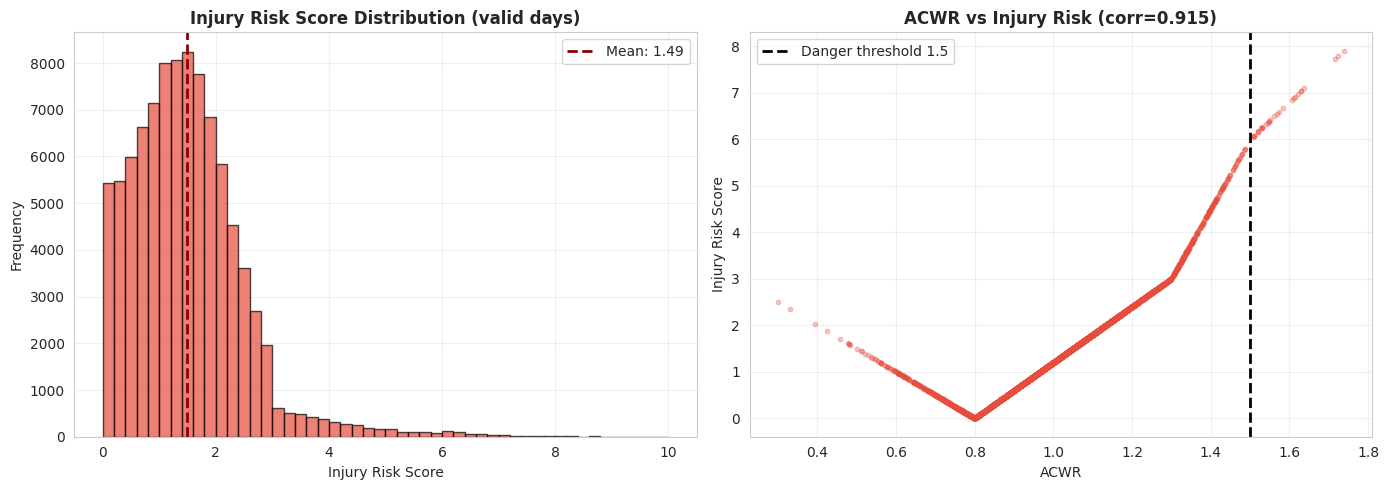

[OK] Visualizzazione salvata: visualizations/IMPETUS_EDA_4_InjuryRisk.png


In [ ]:
# ============================================================================
# CELL 5: Injury Risk Score Validation & Correlations (solo validi)
# ============================================================================
print("\n" + "=" * 80)
print("SEZIONE 4: INJURY RISK SCORE ANALYSIS (Pipeline B Target) - solo validi")
print("=" * 80)

df_risk = df[df['acwr_valid'] & df['injury_risk_score'].notna() & df['acwr'].notna()].copy()
s_risk = df_risk['injury_risk_score']

print("\nSTATISTICHE INJURY RISK SCORE (solo validi):")
print(s_risk.describe())
print()

ranges = [(0, 0.1), (0.1, 1), (1, 3), (3, 6), (6, 10.1)]
print("DISTRIBUZIONE PER RANGE (solo validi):")
for low, high in ranges:
    count = ((s_risk >= low) & (s_risk < high)).sum()
    pct = count / len(s_risk) * 100
    label = f"{low:.1f}-{high:.1f}" if low > 0 else "~0"
    print(f"   {label:10s}: {count:6,} giorni ({pct:5.1f}%)")
print()

print("INJURY RISK SCORE PER EXPERIENCE (solo validi):")
for exp in sorted(df_risk['experience_label'].unique()):
    exp_data = df_risk[df_risk['experience_label'] == exp]['injury_risk_score']
    print(f"   {exp:15s}: mean={exp_data.mean():.2f}, std={exp_data.std():.2f}, median={exp_data.median():.2f}")
print()

corr_acwr_risk = df_risk[['acwr', 'injury_risk_score']].corr().iloc[0, 1]
print(f"CORRELATION ACWR vs Injury Risk (solo validi): {corr_acwr_risk:.3f}")
print()

# esperienza: meglio per-utente (per evitare bias di durata storico)
exp_map = {'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}
df_user = (
    df_risk.groupby(['user_id', 'experience_label'])['injury_risk_score']
          .mean()
          .reset_index(name='risk_mean')
)
df_user['exp_numeric'] = df_user['experience_label'].map(exp_map)
corr_exp_risk_user = df_user[['exp_numeric', 'risk_mean']].corr().iloc[0, 1]
print(f"CORRELATION (per-utente) Experience vs mean risk: {corr_exp_risk_user:.3f}")
print()

# Histogram (fix NaN)
print("[DATI GRAFICO - Injury Risk Score] (solo validi)")
hist_counts, hist_bins = np.histogram(s_risk.values, bins=50, range=(0, 10))
print(f"   Max count: {hist_counts.max()} (bin ~{hist_bins[np.argmax(hist_counts)]:.2f})")
print()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(s_risk.values, bins=50, range=(0,10), color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0].axvline(s_risk.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {s_risk.mean():.2f}')
axes[0].set_xlabel('Injury Risk Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Injury Risk Score Distribution (valid days)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

sample_size = min(5000, len(df_risk))
df_sample = df_risk.sample(n=sample_size, random_state=42)
axes[1].scatter(df_sample['acwr'], df_sample['injury_risk_score'], alpha=0.3, s=10, color='#e74c3c')
axes[1].axvline(ACWR_DANGER_THRESHOLD, color='black', linestyle='--', linewidth=2,
                label=f'Danger threshold {ACWR_DANGER_THRESHOLD}')
axes[1].set_xlabel('ACWR')
axes[1].set_ylabel('Injury Risk Score')
axes[1].set_title(f'ACWR vs Injury Risk (corr={corr_acwr_risk:.3f})', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(viz_dir / 'IMPETUS_EDA_4_InjuryRisk.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Visualizzazione salvata: visualizations/IMPETUS_EDA_4_InjuryRisk.png")


#**CELL 6 - Correlation Matrix**


SEZIONE 5: CORRELATION MATRIX - Features vs Targets

MATRICE CORRELAZIONI COMPLETA (dropna su acwr + injury_risk_score):
                        impulse  fitness  fatigue  performance    TSB   acwr  performance_score_0_10  injury_risk_score
impulse                   1.000    0.860    0.868        0.079  0.821  0.161                   0.671              0.131
fitness                   0.860    1.000    0.928        0.155  0.988  0.054                   0.834              0.028
fatigue                   0.868    0.928    1.000        0.104  0.860  0.119                   0.747              0.089
performance               0.079    0.155    0.104        1.000  0.170 -0.084                   0.192             -0.057
TSB                       0.821    0.988    0.860        0.170  1.000  0.025                   0.835              0.001
acwr                      0.161    0.054    0.119       -0.084  0.025  1.000                   0.037              0.915
performance_score_0_10    0.671    0.8

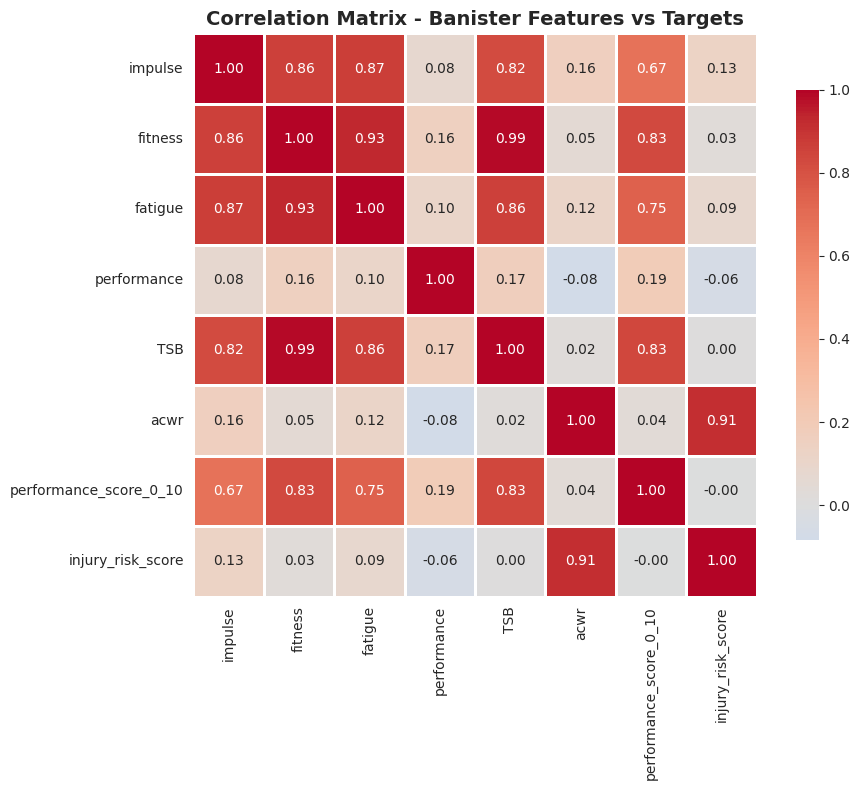

[OK] Visualizzazione salvata: visualizations/IMPETUS_EDA_5_Correlation_Matrix.png


In [ ]:
# ============================================================================
# CELL 6: Correlation Matrix - Features vs Targets
# ============================================================================
print("\n" + "=" * 80)
print("SEZIONE 5: CORRELATION MATRIX - Features vs Targets")
print("=" * 80)

features_to_analyze = [
    'impulse', 'fitness', 'fatigue', 'performance', 'TSB',
    'acwr', 'performance_score_0_10', 'injury_risk_score'
]

# Per la matrice ha senso usare solo righe dove acwr e risk esistono
df_corr = df[features_to_analyze].dropna(subset=['acwr', 'injury_risk_score']).copy()
corr_matrix = df_corr.corr()

print("\nMATRICE CORRELAZIONI COMPLETA (dropna su acwr + injury_risk_score):")
print(corr_matrix.round(3).to_string())
print()

print("TOP 5 CORRELATIONS con performance_score_0_10:")
corr_perf = corr_matrix['performance_score_0_10'].drop('performance_score_0_10').abs().sort_values(ascending=False)
for feat in corr_perf.head(5).index:
    print(f"   {feat:20s}: {corr_matrix.loc[feat, 'performance_score_0_10']:+.3f}")
print()

print("TOP 5 CORRELATIONS con injury_risk_score:")
corr_risk = corr_matrix['injury_risk_score'].drop('injury_risk_score').abs().sort_values(ascending=False)
for feat in corr_risk.head(5).index:
    print(f"   {feat:20s}: {corr_matrix.loc[feat, 'injury_risk_score']:+.3f}")
print()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix - Banister Features vs Targets', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig(viz_dir / 'IMPETUS_EDA_5_Correlation_Matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Visualizzazione salvata: visualizations/IMPETUS_EDA_5_Correlation_Matrix.png")


#**CELL 7 - Temporal Patterns**


SEZIONE 6: TEMPORAL PATTERNS - Time Series Analysis
SAMPLE USERS SELEZIONATI (3 utenti):
   User 84 (Beginner): 164 giorni, periodo 2025-05-15 -> 2026-02-07
   User 1241 (Intermediate): 404 giorni, periodo 2024-07-29 -> 2026-02-08
   User 1079 (Advanced): 659 giorni, periodo 2023-03-04 -> 2026-02-08

[DATI GRAFICO - Time Series]
--------------------------------------------------------------------------------

User 84 (Beginner):
   N giorni: 164 (validi ACWR: 137)
   TSB: mean=243.9, std=117.4
   ACWR(valid): mean=1.014, spike_rate=2.19%
   PerfScore(0-10): mean=0.84
   InjuryRisk(valid): mean=1.63

User 1241 (Intermediate):
   N giorni: 404 (validi ACWR: 377)
   TSB: mean=445.0, std=167.5
   ACWR(valid): mean=1.023, spike_rate=0.00%
   PerfScore(0-10): mean=1.66
   InjuryRisk(valid): mean=1.42

User 1079 (Advanced):
   N giorni: 659 (validi ACWR: 632)
   TSB: mean=1559.5, std=892.9
   ACWR(valid): mean=1.028, spike_rate=0.00%
   PerfScore(0-10): mean=5.92
   InjuryRisk(valid): mean=1

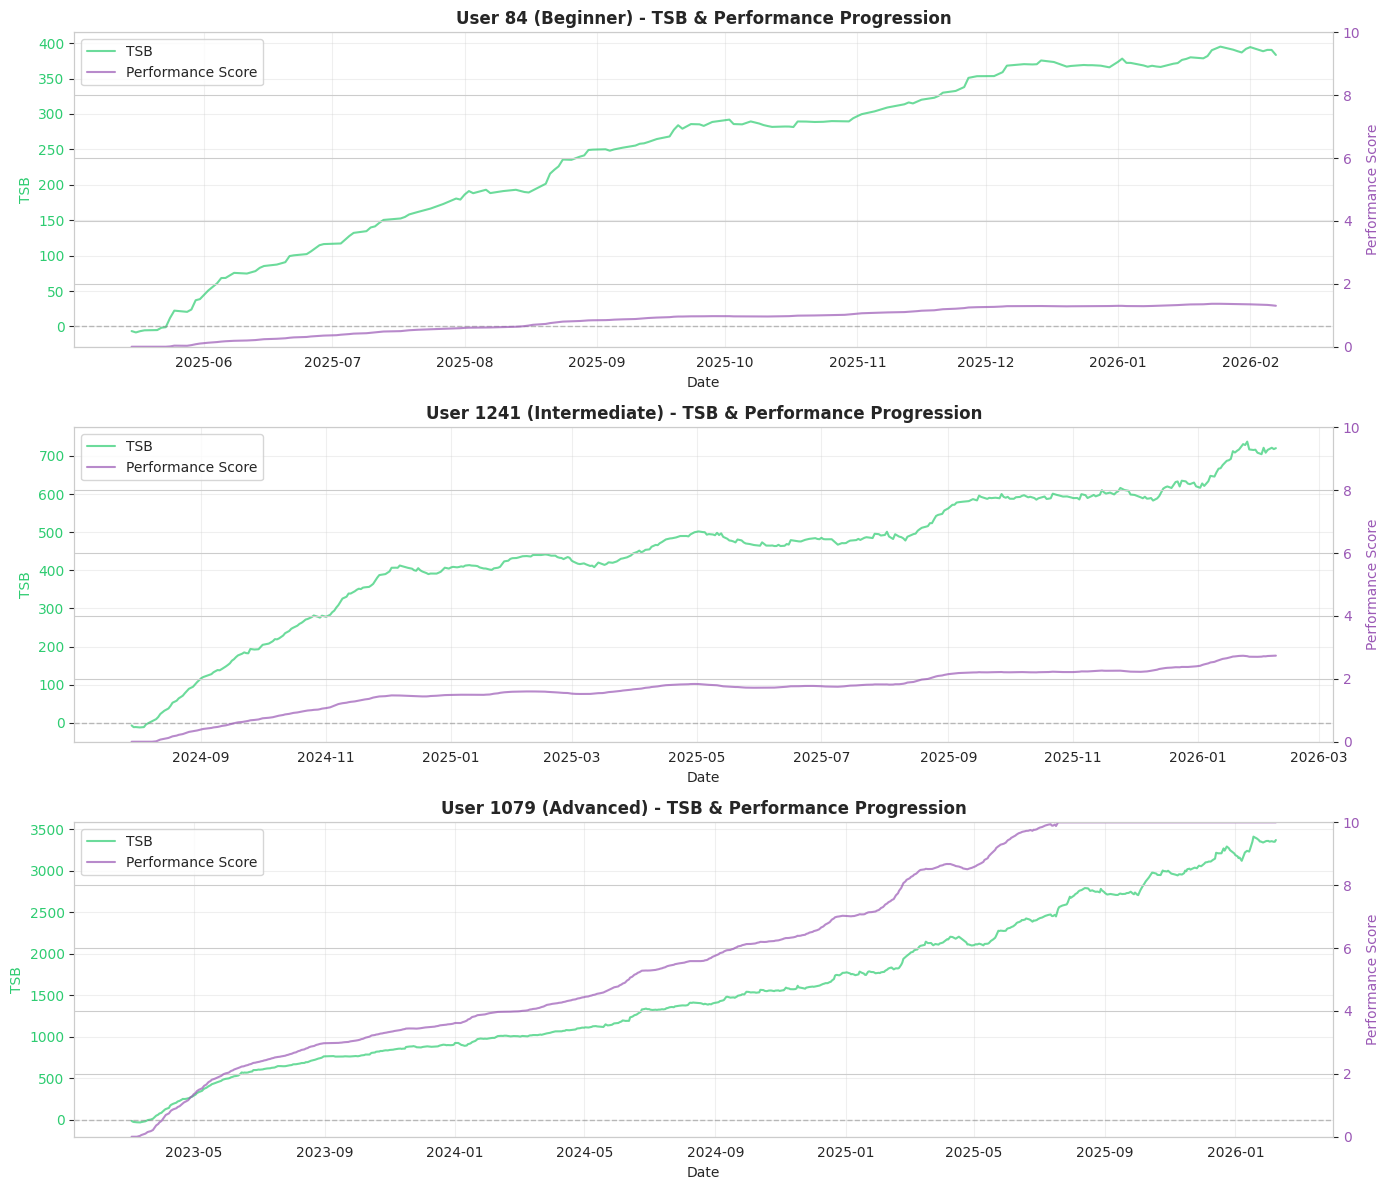

[OK] Visualizzazione salvata: visualizations/IMPETUS_EDA_6_Temporal_Patterns.png


In [ ]:
# ============================================================================
# CELL 7: Temporal Patterns - Time Series Sample Users
# ============================================================================
"""
Analisi temporal patterns su campione utenti rappresentativi.
Verifica progressione, seasonality, trends.
"""

print("\n" + "=" * 80)
print("SEZIONE 6: TEMPORAL PATTERNS - Time Series Analysis")
print("=" * 80)

# Seleziona 3 utenti sample (1 per experience level)
sample_users = []
for exp in ['Beginner', 'Intermediate', 'Advanced']:
    users_exp = df[df['experience_label'] == exp]['user_id'].unique()
    if len(users_exp) > 0:
        # Prendi user con più dati
        user_counts = df[df['user_id'].isin(users_exp)].groupby('user_id').size()
        selected_user = user_counts.idxmax()
        sample_users.append((selected_user, exp))

print(f"SAMPLE USERS SELEZIONATI ({len(sample_users)} utenti):")
for user_id, exp in sample_users:
    user_data = df[df['user_id'] == user_id]
    print(f"   User {user_id} ({exp}): {len(user_data)} giorni, "
          f"periodo {user_data['date'].min().date()} -> {user_data['date'].max().date()}")
print()

print("[DATI GRAFICO - Time Series]")
print("-" * 80)
for user_id, exp in sample_users:
    user_data = df[df['user_id'] == user_id].sort_values('date')
    user_valid = user_data[user_data['acwr_valid'] & user_data['acwr'].notna()]

    spike_rate = (user_valid['acwr'] >= ACWR_DANGER_THRESHOLD).mean() * 100 if len(user_valid) else np.nan

    print(f"\nUser {user_id} ({exp}):")
    print(f"   N giorni: {len(user_data)} (validi ACWR: {len(user_valid)})")
    print(f"   TSB: mean={user_data['TSB'].mean():.1f}, std={user_data['TSB'].std():.1f}")
    print(f"   ACWR(valid): mean={user_valid['acwr'].mean():.3f}, spike_rate={spike_rate:.2f}%")
    print(f"   PerfScore(0-10): mean={user_data['performance_score_0_10'].mean():.2f}")
    print(f"   InjuryRisk(valid): mean={user_valid['injury_risk_score'].mean():.2f}")
print("-" * 80)
print()


# Plot
fig, axes = plt.subplots(len(sample_users), 1, figsize=(14, 4 * len(sample_users)))

if len(sample_users) == 1:
    axes = [axes]

for idx, (user_id, exp) in enumerate(sample_users):
    user_data = df[df['user_id'] == user_id].sort_values('date')

    ax = axes[idx]
    ax2 = ax.twinx()

    # TSB (left axis)
    ax.plot(user_data['date'], user_data['TSB'], color='#2ecc71',
            linewidth=1.5, label='TSB', alpha=0.7)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('TSB', color='#2ecc71')
    ax.tick_params(axis='y', labelcolor='#2ecc71')
    ax.grid(alpha=0.3)

    # Performance Score (right axis)
    ax2.plot(user_data['date'], user_data['performance_score_0_10'], color='#9b59b6',
             linewidth=1.5, label='Performance Score', alpha=0.7)
    ax2.set_ylabel('Performance Score', color='#9b59b6')
    ax2.tick_params(axis='y', labelcolor='#9b59b6')
    ax2.set_ylim(0, 10)

    ax.set_title(f'User {user_id} ({exp}) - TSB & Performance Progression', fontweight='bold')

    # Legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig(viz_dir / 'IMPETUS_EDA_6_Temporal_Patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Visualizzazione salvata: visualizations/IMPETUS_EDA_6_Temporal_Patterns.png")

#**CELL 8 - Data Quality Final Checks**

In [ ]:
# ============================================================================
# CELL 8: Data Quality Final Checks
# ============================================================================
"""
Verifiche finali qualità dati prima di modeling.
"""

print("\n" + "=" * 80)
print("SEZIONE 7: DATA QUALITY FINAL CHECKS")
print("=" * 80)

# Missing values
print("\nMISSING VALUES:")
missing = df.isna().sum()
missing_pct = (df.isna().sum() / len(df) * 100).round(2)
missing_summary = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
})
missing_summary = missing_summary[missing_summary['Missing'] > 0]

if len(missing_summary) > 0:
    print(missing_summary.to_string())
else:
    print("   Nessun missing value [OK]")
print()

# Outliers check (IQR method)
print("OUTLIERS CHECK (IQR method, threshold 3×IQR):")
numeric_cols = ['impulse', 'fitness', 'fatigue', 'TSB', 'acwr',
                'performance_score_0_10', 'injury_risk_score']

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outliers_pct = outliers / len(df) * 100

    print(f"   {col:20s}: {outliers:5,} outliers ({outliers_pct:5.2f}%)")
print()

# Range validation per targets
print("TARGET RANGE VALIDATION:")
targets_ranges = [
    ('performance_score_0_10', 0, 10),
    ('injury_risk_score', 0, 10),
    ('acwr', 0.3, 3.0)
]

for col, min_val, max_val in targets_ranges:
    out_of_range = ((df[col] < min_val) | (df[col] > max_val)).sum()
    print(f"   {col:20s}: range [{min_val}, {max_val}], out_of_range: {out_of_range}")
print()

# Duplicati
print("DUPLICATI:")
duplicates = df.duplicated(subset=['user_id', 'date']).sum()
print(f"   Duplicati (user_id + date): {duplicates}")
print()

# Data consistency
print("DATA CONSISTENCY CHECKS:")

# Check 1: TSB = fitness - fatigue
df['TSB_calc'] = df['fitness'] - df['fatigue']
tsb_diff = (df['TSB'] - df['TSB_calc']).abs()
tsb_inconsistent = (tsb_diff > 0.01).sum()  # Tolerance 0.01
print(f"   TSB = fitness - fatigue: {tsb_inconsistent} inconsistencies")

# Check 2: ACWR > 0
acwr_invalid = (df['acwr'] <= 0).sum()
print(f"   ACWR > 0: {acwr_invalid} invalid values")

# Check 3: Performance score correlato con TSB
corr_check = df[['TSB', 'performance_score_0_10']].corr().iloc[0, 1]
print(f"   TSB vs Performance corr: {corr_check:.3f} ({'OK' if corr_check > 0.5 else 'WARNING'})")

print()

if duplicates == 0 and tsb_inconsistent == 0 and acwr_invalid == 0:
    print("[OK] TUTTI I DATA QUALITY CHECKS SUPERATI")
else:
    print("[WARNING] Alcuni check falliti, vedere dettagli sopra")


SEZIONE 7: DATA QUALITY FINAL CHECKS

MISSING VALUES:
                   Missing  Percentage
acwr                 13737       12.89
injury_risk_score    13737       12.89

OUTLIERS CHECK (IQR method, threshold 3×IQR):
   impulse             : 1,925 outliers ( 1.81%)
   fitness             : 1,354 outliers ( 1.27%)
   fatigue             : 1,969 outliers ( 1.85%)
   TSB                 : 1,268 outliers ( 1.19%)
   acwr                :    41 outliers ( 0.04%)
   performance_score_0_10:     0 outliers ( 0.00%)
   injury_risk_score   :   634 outliers ( 0.59%)

TARGET RANGE VALIDATION:
   performance_score_0_10: range [0, 10], out_of_range: 0
   injury_risk_score   : range [0, 10], out_of_range: 0
   acwr                : range [0.3, 3.0], out_of_range: 0

DUPLICATI:
   Duplicati (user_id + date): 0

DATA CONSISTENCY CHECKS:
   TSB = fitness - fatigue: 0 inconsistencies
   ACWR > 0: 0 invalid values
   TSB vs Performance corr: 0.850 (OK)

[OK] TUTTI I DATA QUALITY CHECKS SUPERATI


#**CELL 9 - Summary Statistics per Experience Level**

In [ ]:
print("\n" + "=" * 80)
print("SEZIONE 8: SUMMARY STATISTICS PER EXPERIENCE LEVEL (user-level)")
print("=" * 80)

df_valid = df[df['acwr_valid'] & df['acwr'].notna() & df['injury_risk_score'].notna()].copy()

# 1) feature user-level: medie per utente (così ogni user pesa 1)
user_perf = df.groupby(['user_id','experience_label']).agg(
    impulse_mean=('impulse','mean'),
    fitness_mean=('fitness','mean'),
    fatigue_mean=('fatigue','mean'),
    TSB_mean=('TSB','mean'),
    perfscore_mean=('performance_score_0_10','mean'),
).reset_index()

user_risk = df_valid.groupby(['user_id','experience_label']).agg(
    acwr_mean=('acwr','mean'),
    risk_mean=('injury_risk_score','mean'),
).reset_index()

user_summary = user_perf.merge(user_risk, on=['user_id','experience_label'], how='left')

# 2) summary per experience (su utenti)
exp_summary = user_summary.groupby('experience_label').agg(
    users=('user_id','nunique'),
    impulse_mean=('impulse_mean','mean'),
    impulse_std=('impulse_mean','std'),
    fitness_mean=('fitness_mean','mean'),
    fitness_std=('fitness_mean','std'),
    fatigue_mean=('fatigue_mean','mean'),
    fatigue_std=('fatigue_mean','std'),
    TSB_mean=('TSB_mean','mean'),
    TSB_std=('TSB_mean','std'),
    acwr_mean=('acwr_mean','mean'),
    acwr_std=('acwr_mean','std'),
    perfscore_mean=('perfscore_mean','mean'),
    perfscore_std=('perfscore_mean','std'),
    risk_mean=('risk_mean','mean'),
    risk_std=('risk_mean','std'),
).round(3)

print("\nSUMMARY (user-level) PER EXPERIENCE:")
print(exp_summary.to_string())
print()

# Danger/spike rate per experience (su giorni validi)
ACWR_SPIKE_GENERATOR = 1.61  # [file:1]
ACWR_DANGER_LIT = 1.50       # [web:3]

print(f"DANGER RATE (ACWR >= {ACWR_DANGER_LIT}) PER EXPERIENCE (valid days):")
for exp in sorted(df_valid['experience_label'].unique()):
    exp_data = df_valid[df_valid['experience_label'] == exp]
    danger_rate = (exp_data['acwr'] >= ACWR_DANGER_LIT).mean() * 100
    print(f"   {exp:15s}: {danger_rate:.2f}%")
print()

print(f"SPIKE RATE (ACWR >= {ACWR_SPIKE_GENERATOR}) PER EXPERIENCE (valid days):")
for exp in sorted(df_valid['experience_label'].unique()):
    exp_data = df_valid[df_valid['experience_label'] == exp]
    spike_rate = (exp_data['acwr'] >= ACWR_SPIKE_GENERATOR).mean() * 100
    print(f"   {exp:15s}: {spike_rate:.2f}%")
print()



SEZIONE 8: SUMMARY STATISTICS PER EXPERIENCE LEVEL (user-level)

SUMMARY (user-level) PER EXPERIENCE:
                  users  impulse_mean  impulse_std  fitness_mean  fitness_std  fatigue_mean  fatigue_std  TSB_mean  TSB_std  acwr_mean  acwr_std  perfscore_mean  perfscore_std  risk_mean  risk_std
experience_label                                                                                                                                                                                    
Advanced            170      4479.049     2066.029      1605.066      807.272       494.974      249.562  1110.092  613.247      1.035     0.016           4.122          1.682      1.467     0.105
Beginner            170       779.106      266.308       181.176       75.666        80.550       37.220   100.626   52.539      1.001     0.079           0.340          0.201      1.575     0.423
Intermediate        170      1685.685      651.263       544.203      247.654       180.314       83.000   36

#**CELL 10 - EDA Summary & Modeling Recommendations**

In [ ]:
# ============================================================================
# CELL 10: EDA Summary & Modeling Recommendations
# ============================================================================
"""
Summary EDA + raccomandazioni per feature engineering e modeling.
"""

print("\n" + "=" * 80)
print("EDA SUMMARY & MODELING RECOMMENDATIONS")
print("=" * 80)

print("\n[1] DATASET OVERVIEW:")
print(f"   - Righe totali: {len(df):,}")
print(f"   - Users: {df['user_id'].nunique()}")
print(f"   - Periodo: {(df['date'].max() - df['date'].min()).days} giorni")
print(f"   - Giorni per user (media): {len(df) / df['user_id'].nunique():.1f}")

print("\n[2] TARGET QUALITY:")

# Pipeline A
print("   Pipeline A (performance_score_0_10):")
print("      - Range atteso: [0, 10]")
print(f"      - Mean: {df['performance_score_0_10'].mean():.2f}, Std: {df['performance_score_0_10'].std():.2f}")
print(f"      - Corr(TSB, PerfScore): {df[['TSB','performance_score_0_10']].corr().iloc[0,1]:.3f}")
print()

# Pipeline B: solo validi
df_valid = df[df['acwr_valid'] & df['acwr'].notna() & df['injury_risk_score'].notna()].copy()

print("   Pipeline B (injury_risk_score):")
print("      - Range atteso: [0, 10] (solo righe valide)")
print(f"      - Mean: {df_valid['injury_risk_score'].mean():.2f}, Std: {df_valid['injury_risk_score'].std():.2f}")
print(f"      - Corr(ACWR, Risk): {df_valid[['acwr','injury_risk_score']].corr().iloc[0,1]:.3f}")
print()

ACWR_SPIKE_GENERATOR = 1.61
spike_rate = (df_valid['acwr'] >= ACWR_SPIKE_GENERATOR).mean() * 100
tsb_pos = (df['TSB'] > 0).mean() * 100

print("\n[3] KEY FINDINGS:")
print(f"   - ACWR spike rate (>= {ACWR_SPIKE_GENERATOR}): {spike_rate:.2f}% (solo giorni validi)")
print(f"   - TSB positivo: {tsb_pos:.1f}% giorni")
print("   - Nota: ACWR e risk hanno missing attesi nei giorni warm-up (acwr_valid=False)")

print("\n[4] MODELING RECOMMENDATIONS:")
print("   Features da usare:")
print("      - Banister base: fitness, fatigue, TSB (tutti)")
print("      - ACWR: Critico per injury risk, moderato per performance")
print("      - Impulse: Utile per context, ma già incorporato in fitness/fatigue")

print("\n   Feature Engineering suggerito:")
print("      - Rolling windows: 7d, 14d, 28d per TSB, ACWR")
print("      - Lag features: TSB_lag_1week, performance_lag_1week")
print("      - Trend features: delta_fitness_4weeks, TSB_trend")
print("      - Interaction terms: TSB × ACWR, fitness × experience")

print("\n   Train/Test Split:")
print("      - Temporal split (NO shuffle): 80/20")
print("      - Validazione: Time-series CV (expanding window)")

print("\n   Modelli ideali:")
print("      - Baseline: Linear Regression, Decision Tree")
print("      - Ensemble: Random Forest, Gradient Boosting")
print("      - Advanced: XGBoost")

print("\n   Metriche successo:")
print("      - Pipeline A: R² > 0.70, MAE < 1.0")
print("      - Pipeline B: R² > 0.65, MAE < 1.5")

print("\n" + "=" * 80)
print("EDA COMPLETATO!")
print("=" * 80)
print()
print("[OK] Visualizzazioni salvate in: visualizations/")
print("[OK] Dataset validato: data/synth_set_level_v2/banister_daily_sampled_fixed.csv")
print()
print("NEXT STEP: IMPETUS_Feature_Engineering.ipynb")



EDA SUMMARY & MODELING RECOMMENDATIONS

[1] DATASET OVERVIEW:
   - Righe totali: 106,571
   - Users: 510
   - Periodo: 1078 giorni
   - Giorni per user (media): 209.0

[2] TARGET QUALITY:
   Pipeline A (performance_score_0_10):
      - Range atteso: [0, 10]
      - Mean: 3.06, Std: 2.80
      - Corr(TSB, PerfScore): 0.850

   Pipeline B (injury_risk_score):
      - Range atteso: [0, 10] (solo righe valide)
      - Mean: 1.49, Std: 1.00
      - Corr(ACWR, Risk): 0.915


[3] KEY FINDINGS:
   - ACWR spike rate (>= 1.61): 0.15% (solo giorni validi)
   - TSB positivo: 95.9% giorni
   - Nota: ACWR e risk hanno missing attesi nei giorni warm-up (acwr_valid=False)

[4] MODELING RECOMMENDATIONS:
   Features da usare:
      - Banister base: fitness, fatigue, TSB (tutti)
      - ACWR: Critico per injury risk, moderato per performance
      - Impulse: Utile per context, ma già incorporato in fitness/fatigue

   Feature Engineering suggerito:
      - Rolling windows: 7d, 14d, 28d per TSB, ACWR
   